In [265]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo
from scipy.stats.mstats import winsorize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier

In [266]:
heart_disease = fetch_ucirepo(id=45)  # ID del dataset "Heart Disease"

# Dataset principal
df = heart_disease.data.original.copy()

# Mostrar tamaño y primeras filas
print("Tamaño del dataset:", df.shape)
df.head()


Tamaño del dataset: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [267]:
df.info

<bound method DataFrame.info of      age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   
302   38    1   3       138   175    0        0      173      0      0.0   

     slope   ca  thal  num  
0        3  0.0   6.0    0

In [268]:
print(df.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')


In [269]:
print(df.dtypes)

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
num           int64
dtype: object


Exploración y detección de nulos + tipos

In [270]:
# Tipos de datos y valores nulos
df.info()
print("\nValores nulos por columna:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  num       303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB

Valores nulos por columna:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num     

Imputación

In [271]:
# Imputación de valores faltantes
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_25452\3208216857.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


### (One-Hot/Label Encoding)

In [272]:
# VAriables Categoricas

# Verificamos columnas categóricas
cat_cols = df.select_dtypes(include=['object']).columns
print("Variables categóricas:", list(cat_cols))

# Aplicar One-Hot Encoding si hay categóricas
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


Variables categóricas: []


In [273]:
# variable a predecir
if 'target' in df.columns:
    target_col = 'target'
elif 'num' in df.columns:
    target_col = 'num'
else:
    print("No se encuentra la variable objetivo. Revisa nombres.")

X = df.drop(columns=target_col)
y = df[target_col]


### Escalamiento de variables numéricas

In [274]:
# Escalar las variables numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir de nuevo a DataFrame con nombres originales
X = pd.DataFrame(X_scaled, columns=X.columns)

# Confirmar
print(" Preprocesamiento completo. Datos listos para modelar.")


 Preprocesamiento completo. Datos listos para modelar.


## Desbalance de clases

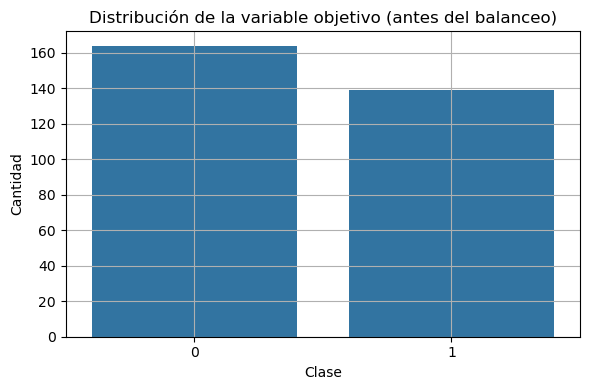

Distribución original:
num
0    164
1    139
Name: count, dtype: int64


In [302]:
# Visualizar distribución original
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Distribución de la variable objetivo (antes del balanceo)")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.grid(True)
plt.tight_layout()
plt.show()

# También puedes imprimir los valores reales
print("Distribución original:")
print(y.value_counts())


In [303]:
# Reemplazar todos los valores mayores a 0 como 1 (presencia de enfermedad)
y = y.apply(lambda val: 1 if val > 0 else 0)


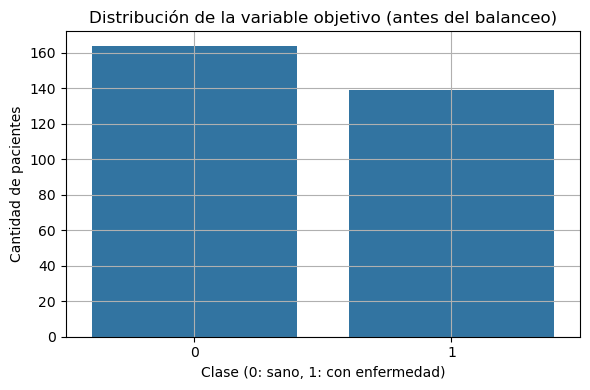

In [304]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title("Distribución de la variable objetivo (antes del balanceo)")
plt.xlabel("Clase (0: sano, 1: con enfermedad)")
plt.ylabel("Cantidad de pacientes")
plt.grid(True)
plt.tight_layout()
plt.show()


Matriz de Confusión (Antes del balanceo):
[[42  7]
 [ 8 34]]


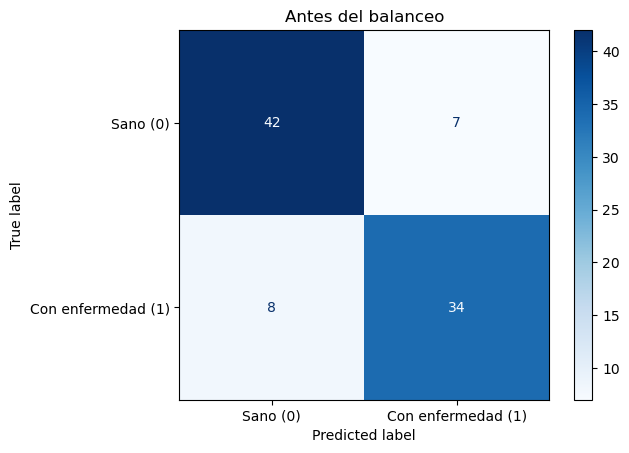

In [305]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# División original sin balanceo
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Modelo simple para evaluar
modelo_base = LogisticRegression(max_iter=1000)
modelo_base.fit(X_train_orig, y_train_orig)
y_pred_orig = modelo_base.predict(X_test_orig)

# Matriz de confusión
cm_orig = confusion_matrix(y_test_orig, y_pred_orig)
print("Matriz de Confusión (Antes del balanceo):")
print(cm_orig)

# Visualización
disp_orig = ConfusionMatrixDisplay(confusion_matrix=cm_orig, display_labels=["Sano (0)", "Con enfermedad (1)"])
disp_orig.plot(cmap="Blues")
plt.title("Antes del balanceo")
plt.show()


###  SMOTE

In [306]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Verificamos la nueva distribución
print("Distribución tras aplicar SMOTE:")
print(y_smote.value_counts())


Distribución tras aplicar SMOTE:
num
0    164
1    164
Name: count, dtype: int64


Distribución de clases en y_smote:
num
0    164
1    164
Name: count, dtype: int64


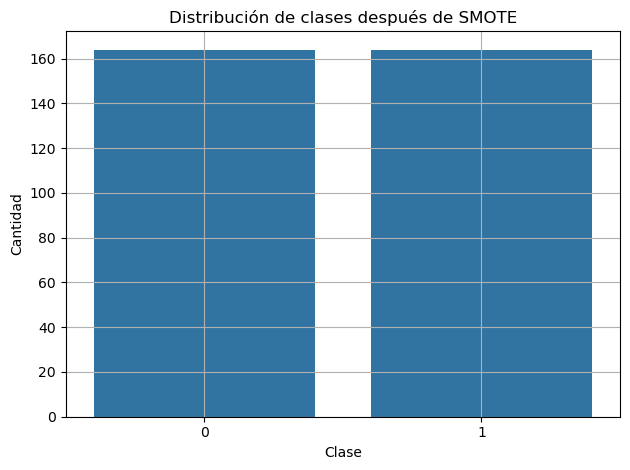

In [307]:
# Si ya aplicaste SMOTE, asegúrate de estar usando y_smote
try:
    print("Distribución de clases en y_smote:")
    print(y_smote.value_counts())

    sns.countplot(x=y_smote)
    plt.title("Distribución de clases después de SMOTE")
    plt.xlabel("Clase")
    plt.ylabel("Cantidad")
    plt.tight_layout()
    plt.grid(True)
    plt.show()
except NameError:
    print(" La variable 'y_smote' no existe. Asegúrate de haber ejecutado el bloque de SMOTE.")


undersampler

In [308]:
undersampler = RandomUnderSampler(random_state=42)
X_under, y_under = undersampler.fit_resample(X, y)

# Verificamos la nueva distribución
print("Distribución tras aplicar Undersampling:")
print(y_under.value_counts())


Distribución tras aplicar Undersampling:
num
0    139
1    139
Name: count, dtype: int64


Distribución de clases en y_smote:
num
0    139
1    139
Name: count, dtype: int64


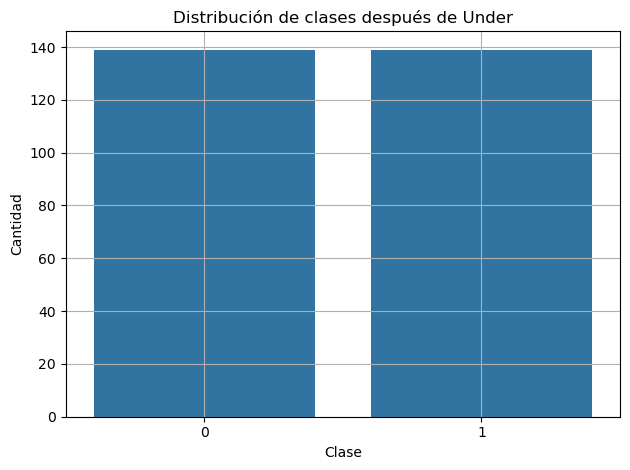

In [309]:
# Si ya aplicaste SMOTE, asegúrate de estar usando y_smote
try:
    print("Distribución de clases en y_smote:")
    print(y_under.value_counts())

    sns.countplot(x=y_under)
    plt.title("Distribución de clases después de Under")
    plt.xlabel("Clase")
    plt.ylabel("Cantidad")
    plt.tight_layout()
    plt.grid(True)
    plt.show()
except NameError:
    print("La variable 'y_under' no existe.")


### Visualización comparativa

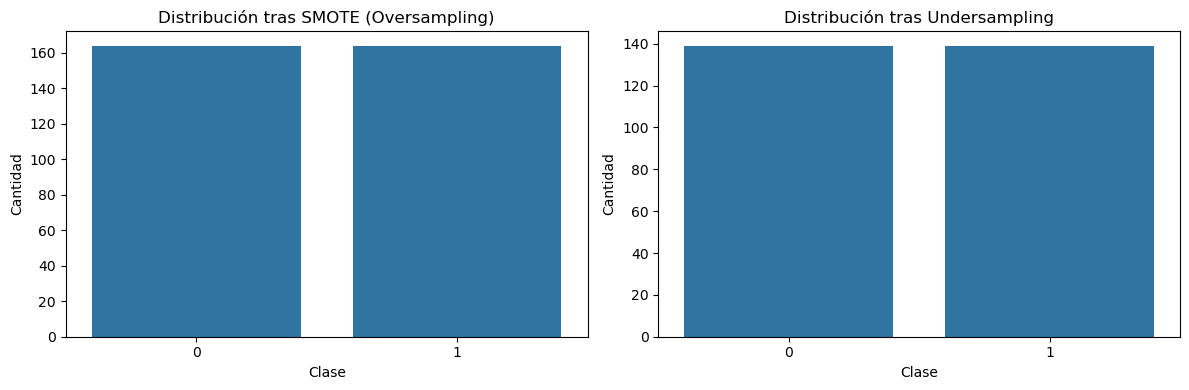

In [310]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x=y_smote, ax=axs[0])
axs[0].set_title("Distribución tras SMOTE (Oversampling)")
axs[0].set_xlabel("Clase")
axs[0].set_ylabel("Cantidad")

sns.countplot(x=y_under, ax=axs[1])
axs[1].set_title("Distribución tras Undersampling")
axs[1].set_xlabel("Clase")
axs[1].set_ylabel("Cantidad")

plt.tight_layout()
plt.show()


Matriz de Confusión (Después de SMOTE):
[[43  7]
 [ 6 43]]


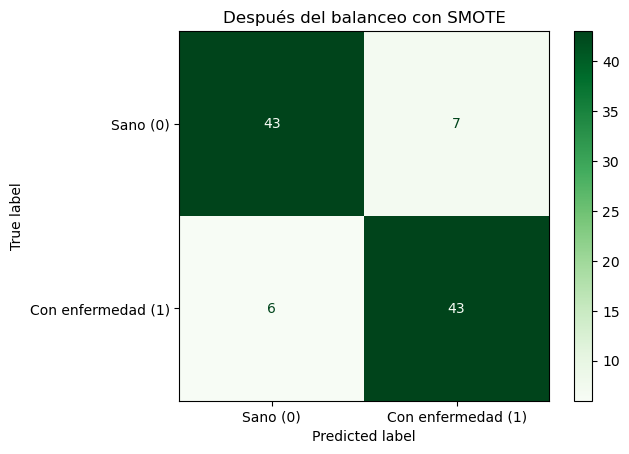

In [311]:
# División con SMOTE
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42, stratify=y_smote)

# Entrenar el mismo modelo con datos balanceados
modelo_smote = LogisticRegression(max_iter=1000)
modelo_smote.fit(X_train_sm, y_train_sm)
y_pred_sm = modelo_smote.predict(X_test_sm)

# Matriz de confusión
cm_sm = confusion_matrix(y_test_sm, y_pred_sm)
print("Matriz de Confusión (Después de SMOTE):")
print(cm_sm)

# Visualización
disp_sm = ConfusionMatrixDisplay(confusion_matrix=cm_sm, display_labels=["Sano (0)", "Con enfermedad (1)"])
disp_sm.plot(cmap="Greens")
plt.title("Después del balanceo con SMOTE")
plt.show()


### USO de PIPELINES
Crear pipeline base (SMOTE + Escalado + Modelo)

In [312]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),                  
    ('scaler', StandardScaler()),                       
    ('classifier', LogisticRegression(max_iter=1000))   
])


Validación Cruzada

In [313]:
# Evaluación con K-Fold (k=5 por defecto)
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

print("Accuracy promedio (pipeline con Logistic Regression):", scores.mean())


Accuracy promedio (pipeline con Logistic Regression): 0.8084699453551911


In [314]:
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])


 Integrar GridSearchCV con pipeline

In [315]:
# GridSearch con hiperparámetros del modelo dentro del pipeline
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)


Mejores parámetros: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Mejor score: 0.8248087431693989


In [316]:
# Predecir con el mejor modelo
y_pred = grid_search.best_estimator_.predict(X)

# Reporte de clasificación
print(classification_report(y, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.96      0.93       164
           1       0.95      0.89      0.92       139

    accuracy                           0.93       303
   macro avg       0.93      0.92      0.93       303
weighted avg       0.93      0.93      0.93       303



### División de datos

In [317]:
from sklearn.model_selection import train_test_split

# División 80% entrenamiento / 20% prueba usando los datos balanceados
X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

print(f"Datos entrenamiento: {X_train.shape}")
print(f"Datos prueba: {X_test.shape}")


Datos entrenamiento: (262, 13)
Datos prueba: (66, 13)


K-Fold Cross Validation 

probar k

In [318]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler



# Probar varios valores de K
k_values = [3, 5, 7, 10, 15]
resultados_k = {}

for k in k_values:
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')
    resultados_k[k] = scores.mean()
    print(f"K={k} → Accuracy promedio: {scores.mean():.4f}")

# Mostrar el mejor
mejor_k = max(resultados_k, key=resultados_k.get)
print(f"\n Mejor valor de K: {mejor_k} con accuracy de {resultados_k[mejor_k]:.4f}")


K=3 → Accuracy promedio: 0.8152
K=5 → Accuracy promedio: 0.8380
K=7 → Accuracy promedio: 0.8218
K=10 → Accuracy promedio: 0.8349
K=15 → Accuracy promedio: 0.8379

 Mejor valor de K: 5 con accuracy de 0.8380


In [319]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression

# Modelo base
model = LogisticRegression(max_iter=1000)

# K-Fold con k=5 (mejor valor encontrado)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores_kfold = cross_val_score(model, X_smote, y_smote, cv=kfold, scoring='accuracy')

# Resultados
print("Resultados K-Fold (k=5):", scores_kfold)
print("Accuracy promedio K-Fold:", scores_kfold.mean())


Resultados K-Fold (k=5): [0.77272727 0.83333333 0.87878788 0.84615385 0.87692308]
Accuracy promedio K-Fold: 0.8415850815850817


In [320]:
from sklearn.model_selection import StratifiedKFold

# Stratified mantiene proporción de clases (incluso después de SMOTE)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_skfold = cross_val_score(model, X_smote, y_smote, cv=skfold, scoring='accuracy')

# Resultados
print("Resultados Stratified K-Fold (k=5):", scores_skfold)
print("Accuracy promedio Stratified K-Fold:", scores_skfold.mean())


Resultados Stratified K-Fold (k=5): [0.83333333 0.86363636 0.8030303  0.8        0.90769231]
Accuracy promedio Stratified K-Fold: 0.8415384615384616


### Validación con LOOCV

In [321]:
from sklearn.model_selection import LeaveOneOut

# Leave-One-Out: uno como prueba, el resto como entrenamiento
loocv = LeaveOneOut()
scores_loocv = cross_val_score(model, X_smote, y_smote, cv=loocv, scoring='accuracy')

# Resultados
print("LOOCV completado.")
print("Accuracy promedio LOOCV:", scores_loocv.mean())


LOOCV completado.
Accuracy promedio LOOCV: 0.8384146341463414


In [322]:
import pandas as pd
from IPython.display import display

resultados = {
    'K-Fold (k=5)': scores_kfold.mean(),
    'Stratified K-Fold (k=5)':scores_skfold.mean(),
    'LOOCV': scores_loocv.mean()
}

# Convertir a DataFrame
df_resultados = pd.DataFrame.from_dict(resultados, orient='index', columns=['Accuracy Promedio'])
df_resultados.index.name = 'Método de Validación'

# Mostrar la tabla bonita
display(df_resultados.style
        .format("{:.4f}")
        .highlight_max(color='lightgreen')
        .set_caption("Comparación de Métodos de Validación Cruzada")
        .set_table_styles([{
            'selector': 'caption',
            'props': [('color', '#0A4D68'),
                      ('font-size', '16px'),
                      ('font-weight', 'bold')]
        }])
        .set_properties(**{'text-align': 'center'}))


,Accuracy Promedio
Método de Validación,
K-Fold (k=5),0.8416
Stratified K-Fold (k=5),0.8415
LOOCV,0.8384


### Modelos a Implementar 

In [323]:
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Pipeline: SMOTE + Escalado + Regresión Logística
pipeline_logreg = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline_logreg.fit(X_train, y_train)
y_pred_logreg = pipeline_logreg.predict(X_test)


Accuracy: 0.8484848484848485
Precision: 0.8285714285714286
Recall: 0.8787878787878788
F1-score: 0.8529411764705882


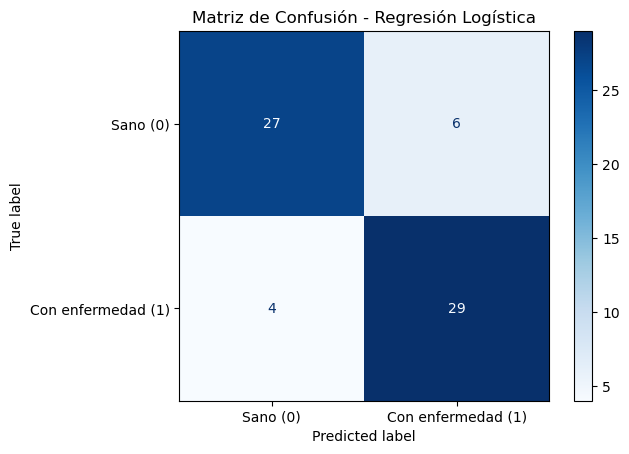

In [324]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Precision:", precision_score(y_test, y_pred_logreg))
print("Recall:", recall_score(y_test, y_pred_logreg))
print("F1-score:", f1_score(y_test, y_pred_logreg))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_logreg)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sano (0)", "Con enfermedad (1)"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()


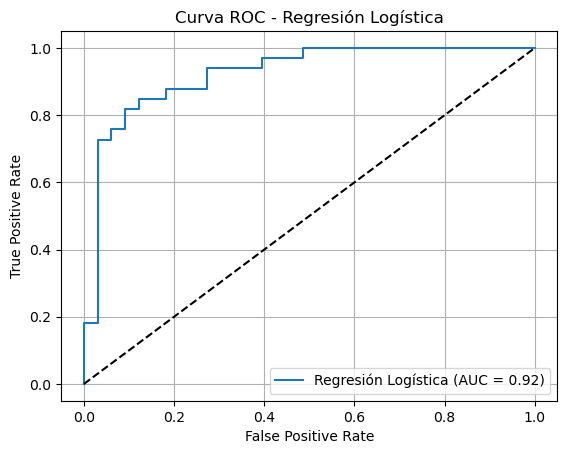

In [325]:
# Obtener probabilidades
y_prob_logreg = pipeline_logreg.predict_proba(X_test)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)
auc_logreg = roc_auc_score(y_test, y_prob_logreg)

plt.plot(fpr, tpr, label=f"Regresión Logística (AUC = {auc_logreg:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Regresión Logística")
plt.legend()
plt.grid(True)
plt.show()


### Pipeline con Árbol de Decisión (sin ajuste)

In [326]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Pipeline: SMOTE + Escalado + Árbol
pipeline_tree = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipeline_tree.fit(X_train, y_train)
y_pred_tree = pipeline_tree.predict(X_test)


Accuracy: 0.7424242424242424
Precision: 0.7105263157894737
Recall: 0.8181818181818182
F1-score: 0.7605633802816901


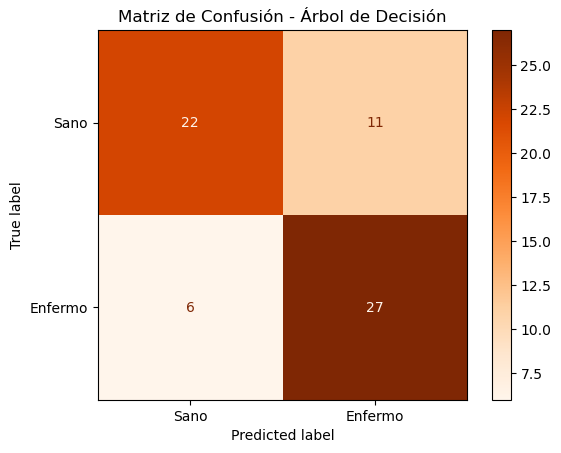

In [327]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Precision:", precision_score(y_test, y_pred_tree))
print("Recall:", recall_score(y_test, y_pred_tree))
print("F1-score:", f1_score(y_test, y_pred_tree))

# Matriz de confusión
cm_tree = confusion_matrix(y_test, y_pred_tree)
disp_tree = ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=["Sano", "Enfermo"])
disp_tree.plot(cmap="Oranges")
plt.title("Matriz de Confusión - Árbol de Decisión")
plt.show()


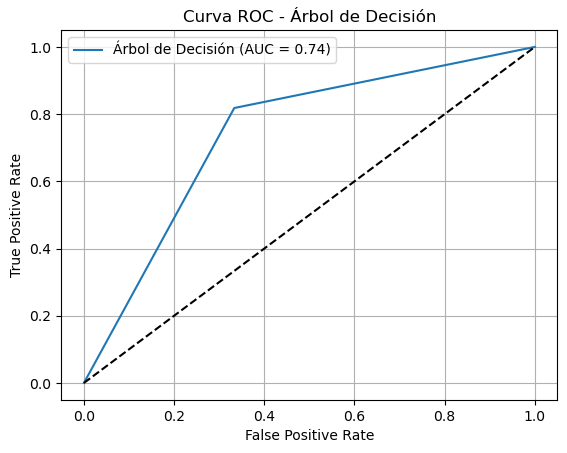

In [328]:
from sklearn.metrics import roc_auc_score, roc_curve

# Probabilidades
y_prob_tree = pipeline_tree.predict_proba(X_test)[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)
auc_tree = roc_auc_score(y_test, y_prob_tree)

plt.plot(fpr_tree, tpr_tree, label=f"Árbol de Decisión (AUC = {auc_tree:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Árbol de Decisión")
plt.legend()
plt.grid(True)
plt.show()


### Con Ajuste de hiperparámetros con GridSearchCV

In [331]:
from sklearn.model_selection import GridSearchCV

# Pipeline base
pipeline_tree_gs = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Parrilla de hiperparámetros
param_grid_tree = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# Validación cruzada estratificada
grid_tree = GridSearchCV(pipeline_tree_gs, param_grid=param_grid_tree, cv=5, scoring='accuracy', n_jobs=-1)
grid_tree.fit(X_train, y_train)

print("Mejores parámetros del Árbol:", grid_tree.best_params_)
print("Mejor Accuracy en validación cruzada:", grid_tree.best_score_)

# Evaluación en test
y_pred_tree_gs = grid_tree.predict(X_test)
print("Accuracy en test (mejor árbol):", accuracy_score(y_test, y_pred_tree_gs))


Mejores parámetros del Árbol: {'classifier__criterion': 'gini', 'classifier__max_depth': 3, 'classifier__min_samples_split': 2}
Mejor Accuracy en validación cruzada: 0.7903483309143686
Accuracy en test (mejor árbol): 0.8181818181818182


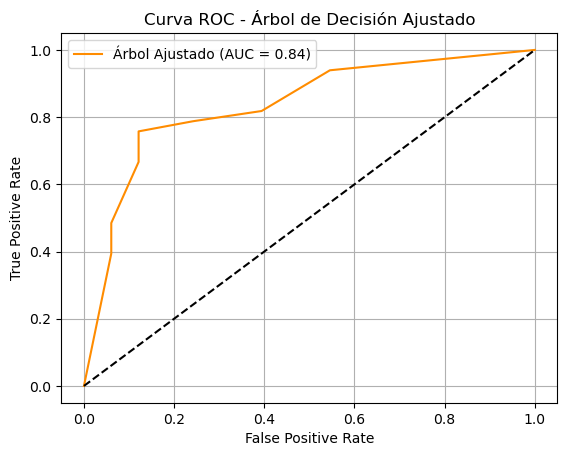

In [332]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Obtener las probabilidades del modelo ajustado
y_prob_tree_gs = grid_tree.best_estimator_.predict_proba(X_test)[:, 1]

# Calcular curva ROC y AUC
fpr_gs, tpr_gs, _ = roc_curve(y_test, y_prob_tree_gs)
auc_gs = roc_auc_score(y_test, y_prob_tree_gs)

# Graficar
plt.plot(fpr_gs, tpr_gs, label=f"Árbol Ajustado (AUC = {auc_gs:.2f})", color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Árbol de Decisión Ajustado")
plt.legend()
plt.grid(True)
plt.show()


#### Random Forest sin ajuste

In [333]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Pipeline base
pipeline_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)


Accuracy: 0.8636363636363636
Precision: 0.875
Recall: 0.8484848484848485
F1-score: 0.8615384615384616


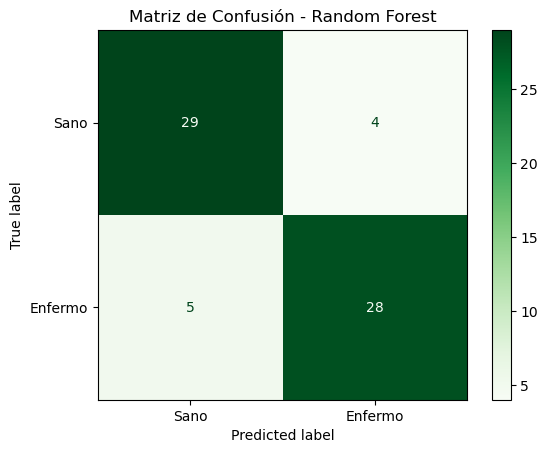

In [334]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Sano", "Enfermo"])
disp_rf.plot(cmap="Greens")
plt.title("Matriz de Confusión - Random Forest")
plt.show()


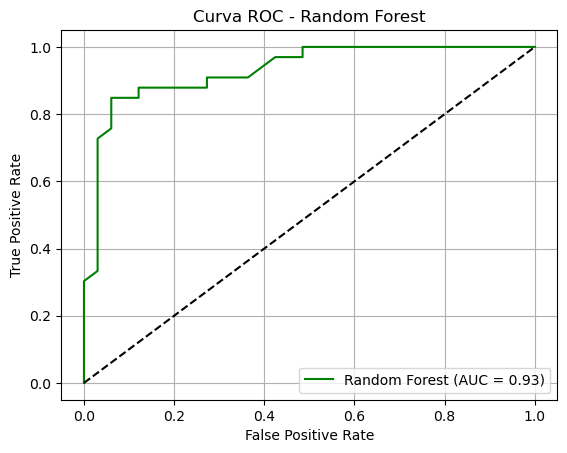

In [335]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilidades
y_prob_rf = pipeline_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)

plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Random Forest")
plt.legend()
plt.grid(True)
plt.show()


#### Ajuste con hiperparametros

In [336]:
from sklearn.model_selection import GridSearchCV

# Pipeline
pipeline_rf_gs = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Parrilla de hiperparámetros
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5]
}

# GridSearchCV con validación cruzada estratificada
grid_rf = GridSearchCV(pipeline_rf_gs, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Mejores parámetros de Random Forest:", grid_rf.best_params_)
print("Mejor Accuracy en validación cruzada:", grid_rf.best_score_)

# Evaluación final
y_pred_rf_gs = grid_rf.predict(X_test)
print("Accuracy en test (Random Forest ajustado):", accuracy_score(y_test, y_pred_rf_gs))


Mejores parámetros de Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 150}
Mejor Accuracy en validación cruzada: 0.8396952104499273
Accuracy en test (Random Forest ajustado): 0.8636363636363636


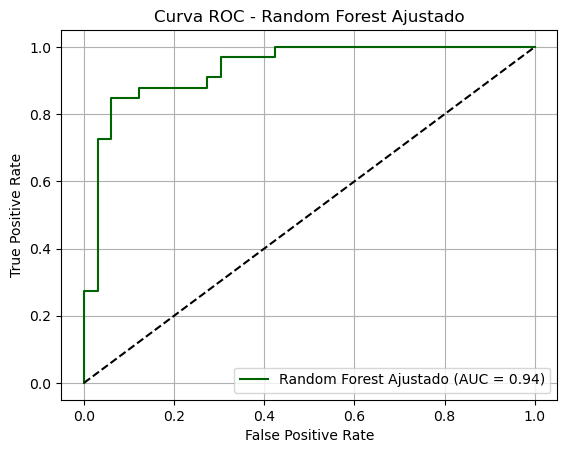

In [337]:
# Probabilidades
y_prob_rf_gs = grid_rf.best_estimator_.predict_proba(X_test)[:, 1]
fpr_rf_gs, tpr_rf_gs, _ = roc_curve(y_test, y_prob_rf_gs)
auc_rf_gs = roc_auc_score(y_test, y_prob_rf_gs)

plt.plot(fpr_rf_gs, tpr_rf_gs, label=f"Random Forest Ajustado (AUC = {auc_rf_gs:.2f})", color='darkgreen')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Random Forest Ajustado")
plt.legend()
plt.grid(True)
plt.show()
